# Zero-day attack detection Using tensor flow 

In [1]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.python.client import device_lib
import time
import seaborn as sns
import matplotlib.gridspec as gridspec

from keras.layers import Input, Dense
from keras import regularizers, Model
from keras.models import Sequential

from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_recall_curve, classification_report, confusion_matrix, average_precision_score, roc_curve, auc

Using TensorFlow backend.


In [2]:
# Make sure that the dataset exists
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

In [3]:
# Importing benign gafgyt combo dataset for a given device id (1-9)
def import_dataset_benign_gagfyt_combo(device_id):
    normal = pd.read_csv('../input/nbaiot-dataset/{}.benign.csv'.format(device_id))
    n_X = normal.iloc[:,]
    n_X_scaled = MinMaxScaler().fit_transform(n_X.values)
    n_y = np.ones(n_X.shape[0]) # 1 represents normal

    anomalous = pd.read_csv('../input/nbaiot-dataset/{}.gafgyt.combo.csv'.format(device_id))
    a_X = anomalous.iloc[:,]
    a_X_scaled = MinMaxScaler().fit_transform(a_X.values)
    a_y = np.zeros(a_X.shape[0]) # 0 represents anomalous

    #normal.info()
    #normal.describe()
    #normal.head()

    #anomalous.info()
    #anomalous.describe()
    #anomalous.head()

    return (n_X_scaled, n_y, a_X_scaled, a_y)

In [4]:
# AutoEncoder

def generate_and_train_autoencoder(X):
    ## input layer 
    input_layer = Input(shape=(X.shape[1],))

    ## encoding part
    encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
    encoded = Dense(50, activation='relu')(encoded)

    ## decoding part
    decoded = Dense(50, activation='tanh')(encoded)
    decoded = Dense(100, activation='tanh')(decoded)

    ## output layer
    output_layer = Dense(X.shape[1], activation='relu')(decoded)

    autoencoder = Model(input_layer, output_layer)
    autoencoder.compile(optimizer="adadelta", loss="mse")

    autoencoder.fit(X[0:1000], X[0:1000], 
                    batch_size = 256, epochs = 10, 
                    shuffle = True, validation_split = 0.20);

    return autoencoder

In [5]:
# hidden representation
def get_hidden_representation_normal_anomalous(autoencoder, n_X, a_X):
    hidden_representation = Sequential()
    hidden_representation.add(autoencoder.layers[0])
    hidden_representation.add(autoencoder.layers[1])
    hidden_representation.add(autoencoder.layers[2])

    normal_hid_rep = hidden_representation.predict(n_X[:3000])
    anomalous_hid_rep = hidden_representation.predict(a_X[:3000])

    return (normal_hid_rep, anomalous_hid_rep)

In [6]:
def tsne_plot(x, y, title="Scatter Plot", name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y == 1), 0], X_t[np.where(y == 1), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Normal')
    plt.scatter(X_t[np.where(y == 0), 0], X_t[np.where(y == 0), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Anomalous')

    plt.title(title)
    plt.legend(loc='best');
    plt.savefig('{}-{}'.format(title,name));
    plt.show();

In [7]:
# Combine normal and anomalous data
def combine_normal_anomalous(normal, anomalous):
    X = np.append(normal, anomalous, axis = 0)
    y_n = np.ones(normal.shape[0])
    y_a = np.zeros(anomalous.shape[0])
    y = np.append(y_n, y_a)

    return (X, y)

In [8]:
# Evaluate model's performace
def evaluate_model(X, y):
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25)
    clf = LogisticRegression(solver="lbfgs").fit(train_X, train_y)
    pred_y = clf.predict(test_X)
    return (test_y, pred_y)

In [9]:
# Show model's report
def show_model_report(title, X, y, hid_X, hid_y, test_y, pred_y):
    #tsne_plot(X, y, '{}-original'.format(title), "original.png")
    tsne_plot(hid_X, hid_y, title, "hidden_representation.png")

    print(title)
    print ("")
    print ("Classification Report: ")
    print (classification_report(test_y, pred_y))

    print ("")
    print ("Accuracy Score: ", accuracy_score(test_y, pred_y))

In [10]:
# Detect zero-day attack
def detect_zero_day_attack(device_name, device_id):
    (n_X_scaled, n_y, a_X_scaled, a_y) = import_dataset_benign_gagfyt_combo(device_id)
    autoencoder = generate_and_train_autoencoder(n_X_scaled)
    (normal_hid_rep, anomalous_hid_rep) = get_hidden_representation_normal_anomalous(autoencoder, n_X_scaled, a_X_scaled)
    (X, y) = combine_normal_anomalous(n_X_scaled, a_X_scaled)
    (hid_X, hid_y) = combine_normal_anomalous(normal_hid_rep, anomalous_hid_rep)
    (test_y, pred_y) = evaluate_model(hid_X, hid_y)
    show_model_report(device_name, X, y, hid_X, hid_y, test_y, pred_y)

Train on 800 samples, validate on 200 samples
Epoch 1/10
800/800 [==============================] - 0s 433us/step - loss: 0.4527 - val_loss: 0.2992
Epoch 2/10
800/800 [==============================] - 0s 20us/step - loss: 0.3455 - val_loss: 0.2229
Epoch 3/10
800/800 [==============================] - 0s 19us/step - loss: 0.2649 - val_loss: 0.1695
Epoch 4/10
800/800 [==============================] - 0s 19us/step - loss: 0.2109 - val_loss: 0.1347
Epoch 5/10
800/800 [==============================] - 0s 19us/step - loss: 0.1770 - val_loss: 0.1124
Epoch 6/10
800/800 [==============================] - 0s 19us/step - loss: 0.1532 - val_loss: 0.0955
Epoch 7/10
800/800 [==============================] - 0s 19us/step - loss: 0.1352 - val_loss: 0.0857
Epoch 8/10
800/800 [==============================] - 0s 18us/step - loss: 0.1251 - val_loss: 0.0774
Epoch 9/10
800/800 [==============================] - 0s 19us/step - loss: 0.1166 - val_loss: 0.0720
Epoch 10/10
800/800 [=======================

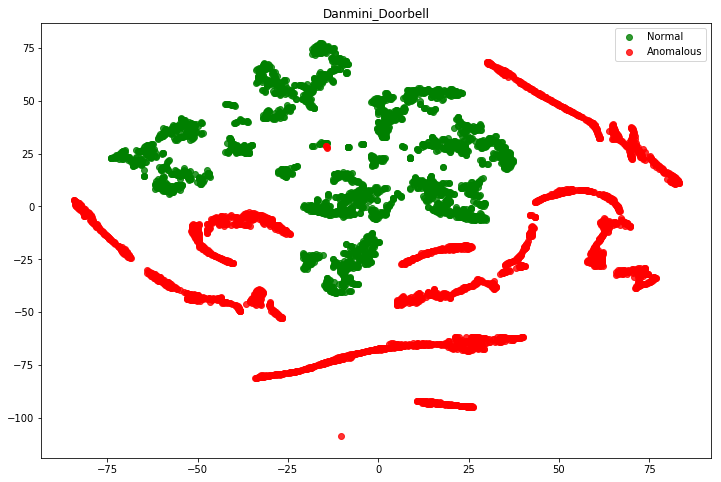

Danmini_Doorbell

Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       731
         1.0       1.00      1.00      1.00       769

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500


Accuracy Score:  1.0
Train on 800 samples, validate on 200 samples
Epoch 1/10
800/800 [==============================] - 0s 258us/step - loss: 0.5919 - val_loss: 0.3791
Epoch 2/10
800/800 [==============================] - 0s 19us/step - loss: 0.4418 - val_loss: 0.2885
Epoch 3/10
800/800 [==============================] - 0s 18us/step - loss: 0.3478 - val_loss: 0.2304
Epoch 4/10
800/800 [==============================] - 0s 18us/step - loss: 0.2861 - val_loss: 0.1914
Epoch 5/10
800/800 [==============================] - 0s 21us/step - loss: 0.2460 - val_loss: 0.1690
Epoch 6/10
800/800 [==============================] - 0s 

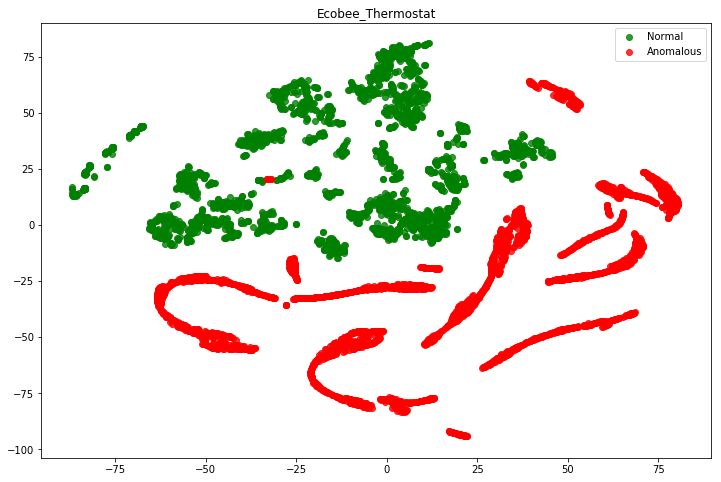

Ecobee_Thermostat

Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       784
         1.0       1.00      1.00      1.00       716

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500


Accuracy Score:  1.0
Train on 800 samples, validate on 200 samples
Epoch 1/10
800/800 [==============================] - 0s 249us/step - loss: 0.6112 - val_loss: 0.4133
Epoch 2/10
800/800 [==============================] - 0s 21us/step - loss: 0.4711 - val_loss: 0.3131
Epoch 3/10
800/800 [==============================] - 0s 17us/step - loss: 0.3649 - val_loss: 0.2387
Epoch 4/10
800/800 [==============================] - 0s 18us/step - loss: 0.2859 - val_loss: 0.1863
Epoch 5/10
800/800 [==============================] - 0s 18us/step - loss: 0.2303 - val_loss: 0.1497
Epoch 6/10
800/800 [==============================] - 0s

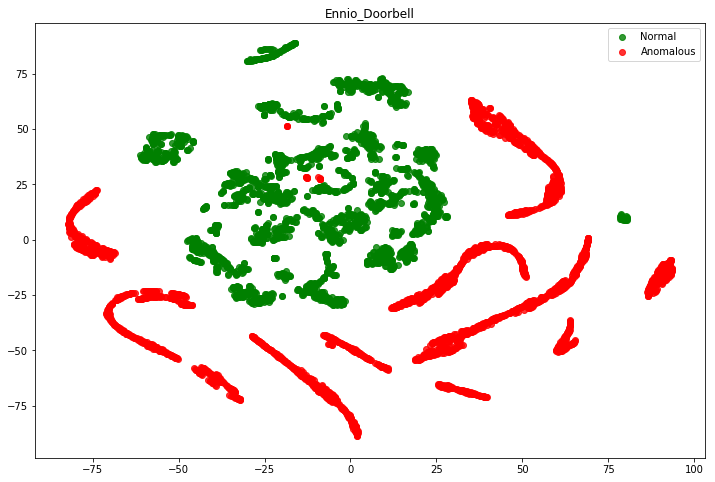

Ennio_Doorbell

Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       755
         1.0       1.00      1.00      1.00       745

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500


Accuracy Score:  0.9986666666666667
Train on 800 samples, validate on 200 samples
Epoch 1/10
800/800 [==============================] - 0s 248us/step - loss: 1.1379 - val_loss: 0.6986
Epoch 2/10
800/800 [==============================] - 0s 20us/step - loss: 0.7613 - val_loss: 0.6430
Epoch 3/10
800/800 [==============================] - 0s 19us/step - loss: 0.5220 - val_loss: 0.6089
Epoch 4/10
800/800 [==============================] - 0s 19us/step - loss: 0.4098 - val_loss: 0.6086
Epoch 5/10
800/800 [==============================] - 0s 19us/step - loss: 0.3779 - val_loss: 0.6105
Epoch 6/10
800/800 [========================

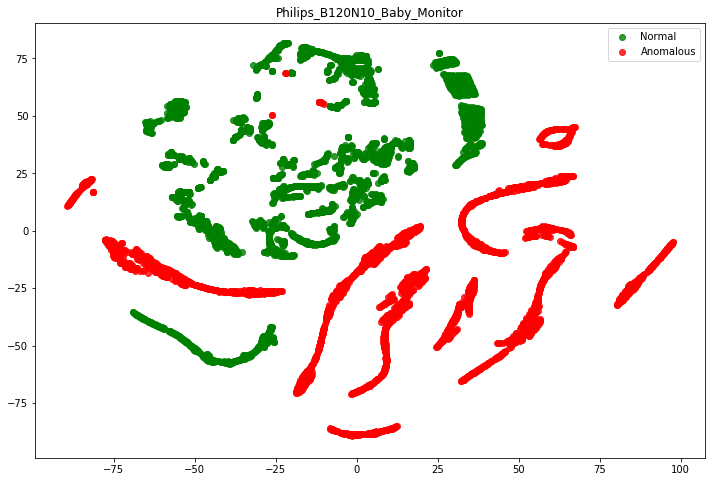

Philips_B120N10_Baby_Monitor

Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       759
         1.0       1.00      1.00      1.00       741

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500


Accuracy Score:  0.998
Train on 800 samples, validate on 200 samples
Epoch 1/10
800/800 [==============================] - 0s 252us/step - loss: 0.4884 - val_loss: 0.2404
Epoch 2/10
800/800 [==============================] - 0s 18us/step - loss: 0.3924 - val_loss: 0.1921
Epoch 3/10
800/800 [==============================] - 0s 18us/step - loss: 0.3234 - val_loss: 0.1566
Epoch 4/10
800/800 [==============================] - 0s 17us/step - loss: 0.2756 - val_loss: 0.1299
Epoch 5/10
800/800 [==============================] - 0s 18us/step - loss: 0.2428 - val_loss: 0.1100
Epoch 6/10
800/800 [=======================

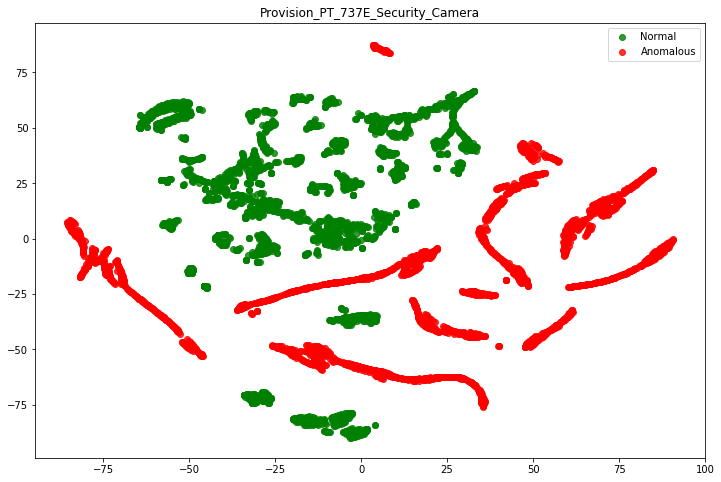

Provision_PT_737E_Security_Camera

Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       759
         1.0       1.00      1.00      1.00       741

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500


Accuracy Score:  1.0
Train on 800 samples, validate on 200 samples
Epoch 1/10
800/800 [==============================] - 0s 248us/step - loss: 0.5095 - val_loss: 0.4063
Epoch 2/10
800/800 [==============================] - 0s 19us/step - loss: 0.4139 - val_loss: 0.3323
Epoch 3/10
800/800 [==============================] - 0s 17us/step - loss: 0.3420 - val_loss: 0.2755
Epoch 4/10
800/800 [==============================] - 0s 20us/step - loss: 0.2910 - val_loss: 0.2345
Epoch 5/10
800/800 [==============================] - 0s 18us/step - loss: 0.2530 - val_loss: 0.2029
Epoch 6/10
800/800 [====================

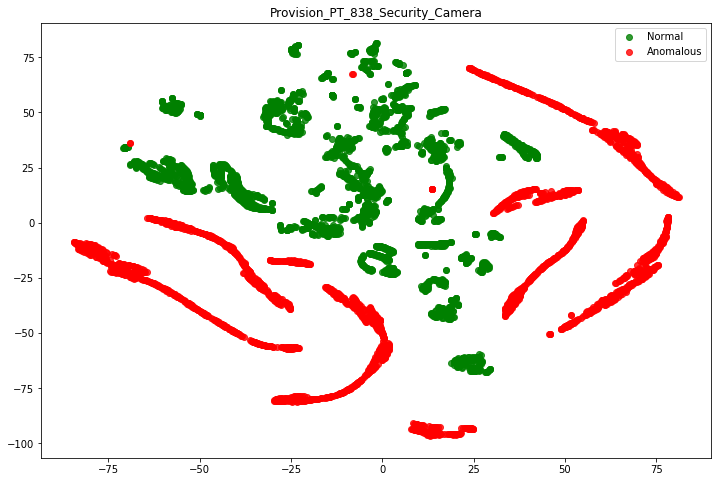

Provision_PT_838_Security_Camera

Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       774
         1.0       1.00      1.00      1.00       726

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500


Accuracy Score:  1.0
Train on 800 samples, validate on 200 samples
Epoch 1/10
800/800 [==============================] - 0s 250us/step - loss: 0.6015 - val_loss: 0.4042
Epoch 2/10
800/800 [==============================] - 0s 19us/step - loss: 0.4594 - val_loss: 0.3040
Epoch 3/10
800/800 [==============================] - 0s 19us/step - loss: 0.3566 - val_loss: 0.2340
Epoch 4/10
800/800 [==============================] - 0s 18us/step - loss: 0.2890 - val_loss: 0.1900
Epoch 5/10
800/800 [==============================] - 0s 18us/step - loss: 0.2447 - val_loss: 0.1583
Epoch 6/10
800/800 [=====================

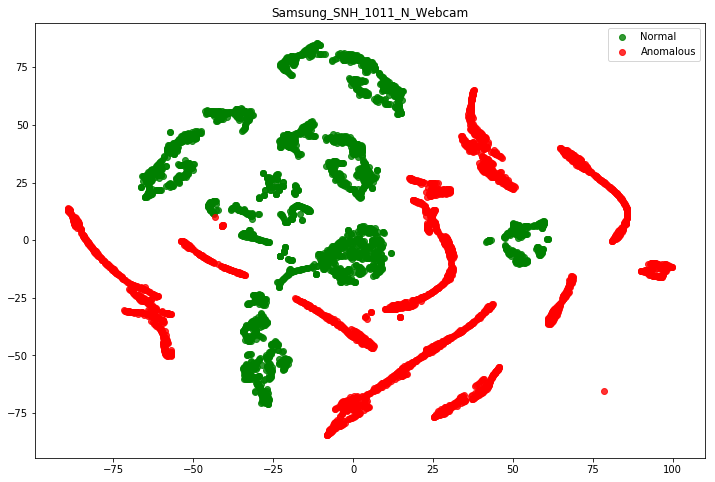

Samsung_SNH_1011_N_Webcam

Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       737
         1.0       1.00      1.00      1.00       763

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500


Accuracy Score:  1.0
Train on 800 samples, validate on 200 samples
Epoch 1/10
800/800 [==============================] - 0s 252us/step - loss: 0.6330 - val_loss: 0.4787
Epoch 2/10
800/800 [==============================] - 0s 20us/step - loss: 0.5051 - val_loss: 0.3979
Epoch 3/10
800/800 [==============================] - 0s 18us/step - loss: 0.4116 - val_loss: 0.3407
Epoch 4/10
800/800 [==============================] - 0s 19us/step - loss: 0.3475 - val_loss: 0.2994
Epoch 5/10
800/800 [==============================] - 0s 20us/step - loss: 0.2989 - val_loss: 0.2677
Epoch 6/10
800/800 [============================

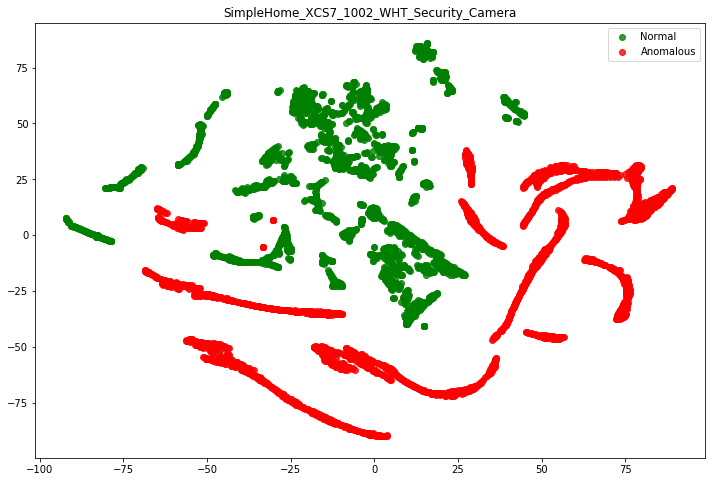

SimpleHome_XCS7_1002_WHT_Security_Camera

Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       766
         1.0       1.00      1.00      1.00       734

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500


Accuracy Score:  1.0
Train on 800 samples, validate on 200 samples
Epoch 1/10
800/800 [==============================] - 0s 248us/step - loss: 0.5873 - val_loss: 0.3603
Epoch 2/10
800/800 [==============================] - 0s 21us/step - loss: 0.4591 - val_loss: 0.2725
Epoch 3/10
800/800 [==============================] - 0s 18us/step - loss: 0.3692 - val_loss: 0.2115
Epoch 4/10
800/800 [==============================] - 0s 18us/step - loss: 0.3065 - val_loss: 0.1667
Epoch 5/10
800/800 [==============================] - 0s 18us/step - loss: 0.2600 - val_loss: 0.1313
Epoch 6/10
800/800 [=============

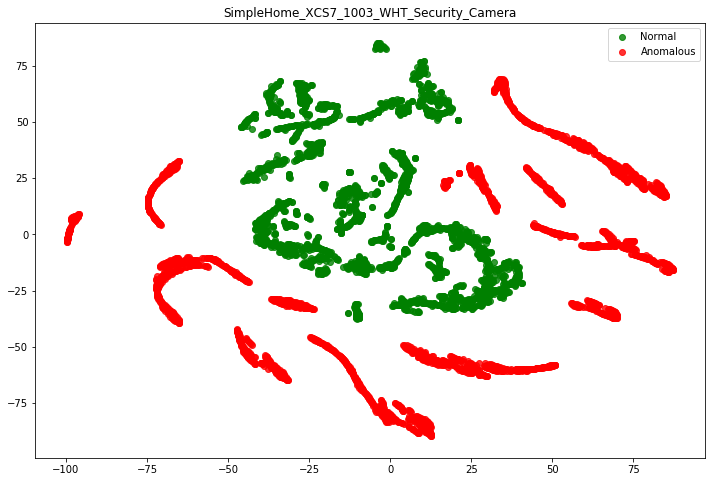

SimpleHome_XCS7_1003_WHT_Security_Camera

Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       749
         1.0       1.00      1.00      1.00       751

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500


Accuracy Score:  0.9993333333333333


In [11]:
devices = ['Danmini_Doorbell', 'Ecobee_Thermostat', 'Ennio_Doorbell', 'Philips_B120N10_Baby_Monitor', 'Provision_PT_737E_Security_Camera', 'Provision_PT_838_Security_Camera', 'Samsung_SNH_1011_N_Webcam', 'SimpleHome_XCS7_1002_WHT_Security_Camera', 'SimpleHome_XCS7_1003_WHT_Security_Camera']
#devices = ['Danmini_Doorbell', 'Ecobee_Thermostat']
for device_id, device_name in enumerate(devices, 1):
    detect_zero_day_attack(device_name, device_id)
